<div style="background-color: #2d2d2d; color: #f8f8f2; padding: 10px; border-radius: 5px; text-align: center;">
2. Model Training for Gemstone Dataset - Ajwar CK
</div>

#### Loading the necessary Libraries

In [1]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

<div style="background-color: #2d2d2d; color: #f8f8f2; padding: 10px; border-radius: 5px; text-align: center;">
Read the Dataset
</div>

In [2]:
df = pd.read_csv('./data/gemstone.csv')
df.head(2)

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.52,Premium,F,VS2,62.2,58.0,7.27,7.33,4.55,13619
1,1,2.03,Very Good,J,SI2,62.0,58.0,8.06,8.12,5.05,13387


#### Dropping id column

In [3]:
df = df.drop(columns=['id'],axis=1)

<div style="background-color: #2d2d2d; color: #f8f8f2; padding: 10px; border-radius: 5px; text-align: center;">
Getting X and Y variables
</div>

In [4]:
X = df.drop(columns=['price'],axis=1)
Y = df[['price']]

<div style="background-color: #2d2d2d; color: #f8f8f2; padding: 10px; border-radius: 5px; text-align: center;">
Creating Data Transformation Pipeline
</div>

#### Creating Pipeline with Column Transformer

In [5]:
X.dtypes[X.dtypes=='object']

cut        object
color      object
clarity    object
dtype: object

In [6]:
X.select_dtypes(include='object').columns

Index(['cut', 'color', 'clarity'], dtype='object')

In [7]:
# Define which columns should be ordinal-encoded and wihich should be scaled.
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(exclude='object').columns.tolist()

# Define custom ranking for each ordinal variables
cut_categories = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
color_categories = ['D', 'E', 'F', 'G', 'H', 'I', 'J']
clarity_categories = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

# Numerical Pipeline
num_pipeline = Pipeline(
    steps = [
        ('imputer',SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

# Categorical  Pipeline
cat_pipeline = Pipeline(
    steps = [
        ('imputer',SimpleImputer(strategy='most_frequent')),
        ('ordinal_encoder',OrdinalEncoder(categories=[cut_categories, color_categories, clarity_categories])),
        ('scaler', StandardScaler())
    ]
)

preprocessor = ColumnTransformer(
    [
    ('num_pipeline',num_pipeline,numerical_cols),
    ('cat_pipeline',cat_pipeline,categorical_cols)
    ]
)

<div style="background-color: #2d2d2d; color: #f8f8f2; padding: 10px; border-radius: 5px; text-align: center;">
Train Test Split
</div>

In [8]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X,Y,test_size=0.2,random_state=42)

<div style="background-color: #2d2d2d; color: #f8f8f2; padding: 10px; border-radius: 5px; text-align: center;">
Transformation the data with pipeline created
</div>

In [9]:
xtrain = pd.DataFrame(preprocessor.fit_transform(xtrain),columns=preprocessor.get_feature_names_out())
xtest = pd.DataFrame(preprocessor.transform(xtest),columns=preprocessor.get_feature_names_out())

In [10]:
preprocessor.get_feature_names_out()

array(['num_pipeline__carat', 'num_pipeline__depth',
       'num_pipeline__table', 'num_pipeline__x', 'num_pipeline__y',
       'num_pipeline__z', 'cat_pipeline__cut', 'cat_pipeline__color',
       'cat_pipeline__clarity'], dtype=object)

In [11]:
preprocessor

ColumnTransformer(transformers=[('num_pipeline',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['carat', 'depth', 'table', 'x', 'y', 'z']),
                                ('cat_pipeline',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['D',
                                                                              'E',
                                                                              'F',
                                                                              'G',
                                                                              'H',
                                                                              'I',
                                                                              'J'],
                                                                             ['I1',
                                                                              'SI2',
                                                                              'SI1',
                                                                              'VS2',
                                                                              'VS1',
                                                                              'VVS2',
                                                                              'VVS1',
                                                                              'IF']])),
                                                 ('scaler', StandardScaler())]),
                                 ['cut', 'color', 'clarity'])])

In [12]:
xtrain.head(2)

,num_pipeline__carat,num_pipeline__depth,num_pipeline__table,num_pipeline__x,num_pipeline__y,num_pipeline__z,cat_pipeline__cut,cat_pipeline__color,cat_pipeline__clarity
0,-1.016395,-0.204317,0.402608,-1.202472,-1.187395,-1.194148,-0.132842,-0.936018,-0.648950
1,0.882396,0.720758,-0.118536,0.985177,0.941823,1.036109,-0.132842,-0.320002,0.017052


In [13]:
xtest.head(2)

,num_pipeline__carat,num_pipeline__depth,num_pipeline__table,num_pipeline__x,num_pipeline__y,num_pipeline__z,cat_pipeline__cut,cat_pipeline__color,cat_pipeline__clarity
0,-0.628006,0.258221,-0.118536,-0.599293,-0.580341,-0.571414,0.872563,-1.552034,-0.648950
1,2.608569,-2.146973,-0.118536,2.128516,2.201232,1.962969,-1.138246,0.296015,-1.314953


<div style="background-color: #2d2d2d; color: #f8f8f2; padding: 10px; border-radius: 5px; text-align: center;">
Model Training Baseline Models
</div>

#### Create an Evaluate Function to give all metrics after model Training

In [14]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

#### Training Various Models

In [15]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(xtrain, ytrain.values.flatten()) # Train model

    # Make predictions
    y_train_pred = model.predict(xtrain)
    y_test_pred = model.predict(xtest)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(ytrain, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(ytest, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 1016.9490
- Mean Absolute Error: 677.1656
- R2 Score: 0.9366
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1006.6010
- Mean Absolute Error: 671.5856
- R2 Score: 0.9373


Lasso
Model performance for Training set
- Root Mean Squared Error: 1017.0718
- Mean Absolute Error: 678.3145
- R2 Score: 0.9366
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1006.8716
- Mean Absolute Error: 672.8635
- R2 Score: 0.9373


Ridge
Model performance for Training set
- Root Mean Squared Error: 1016.9491
- Mean Absolute Error: 677.1925
- R2 Score: 0.9366
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1006.6062
- Mean Absolute Error: 671.6137
- R2 Score: 0.9373


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 545.6502
- Mean Absolute Error: 285.8150
- R2 Sco

#### Results

In [16]:
df_results = pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=['R2_Score'],ascending=False)
df_results

,Model Name,R2_Score
7,CatBoosting Regressor,0.979186
6,XGBRegressor,0.978790
5,Random Forest Regressor,0.977074
3,K-Neighbors Regressor,0.972114
4,Decision Tree,0.956471
0,Linear Regression,0.937298
2,Ridge,0.937297
1,Lasso,0.937264
8,AdaBoost Regressor,0.896279


<div style="background-color: #2d2d2d; color: #f8f8f2; padding: 10px; border-radius: 5px; text-align: center;">
Hyperparameter Tuning
</div>

#### Tuning Catboost

In [17]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [18]:
# Initializing catboost
cbr = CatBoostRegressor(verbose=False)

# Creating the hyperparameter grid
param_dist = {'depth': [4,5,6,7,8,9,10],
              'learning_rate': [0.01,0.02,0.03,0.04],
              'iterations': [300,400,500,600]}

# Instantiate RandomSearchCV object
rscv = RandomizedSearchCV(cbr, param_dist, scoring='r2', cv=5, n_jobs=-1)

# Fit the model
rscv.fit(xtrain, ytrain.values.flatten())

# Print the tuned parameters and score
print(rscv.best_params_)
print(rscv.best_score_)

{'learning_rate': 0.04, 'iterations': 400, 'depth': 8}
0.9797107670070183


#### Definition to print evaluated model results

In [19]:
def print_evaluated_results(model,xtrain,ytrain,xtest,ytest):
    ytrain_pred = model.predict(xtrain)
    ytest_pred = model.predict(xtest)

    # Evaluate Train and Test dataset
    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(ytrain, ytrain_pred)
    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(ytest, ytest_pred) 

    # Printing results
    print('Model Performance for Training set')
    print('- Root Mean Squared Error: {:4f}'.format(model_train_rmse))
    print('- Mean Absolute Error: {:4f}'.format(model_train_mae))
    print('- R2 Score: {:.4f}'.format(model_train_r2))

    print('-------------------------------------------')

    print('Model performane for the Test set')
    print('- Root Mean Squared Error: {:.4f}'.format(model_test_rmse))
    print('- Mean Absolute Error: {:.4f}'.format(model_test_mae))
    print('- R2 Score: {:.4f}'.format(model_test_r2))

In [20]:
# Selecting best model
best_cbr = rscv.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_cbr,xtrain,ytrain,xtest,ytest)

Model Performance for Training set
- Root Mean Squared Error: 558.497398
- Mean Absolute Error: 294.667355
- R2 Score: 0.9809
-------------------------------------------
Model performane for the Test set
- Root Mean Squared Error: 577.5073
- Mean Absolute Error: 297.9377
- R2 Score: 0.9794


#### Tuning KNN

In [21]:
# Intilize knn
knn = KNeighborsRegressor()

# parameters
k_range = list(range(2,31))
param_grid = dict(n_neighbors=k_range)

# Fitting the cv model
grid = GridSearchCV(knn, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(xtrain, ytrain)

# Print the tuned parameters and score
print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 16}
0.9736030364888257


In [22]:
# Selecting best model
best_knn = grid.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_knn, xtrain, ytrain, xtest, ytest)

Model Performance for Training set
- Root Mean Squared Error: 610.346888
- Mean Absolute Error: 319.394287
- R2 Score: 0.9772
-------------------------------------------
Model performane for the Test set
- Root Mean Squared Error: 643.8480
- Mean Absolute Error: 336.3513
- R2 Score: 0.9743


#### Tuning XGBoost

In [23]:
# Initilizing xgboost
xgb = XGBRegressor()

# Parameters
params = {
    'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
    'max_depth' : [3,4,5,6,8,10,12,15],
    'min_child_weight' : [1,3,5,6,7],
    'gamma' : [0.0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree' : [0.3, 0.4, 0.5, 0.7],
    'n_estimators' : [300, 400, 500, 600]
}

rs_xgb = RandomizedSearchCV(xgb, param_distributions=params, scoring='r2', n_jobs=-1, cv=5)
rs_xgb.fit(xtrain, ytrain.values.flatten())

# Print the tuned parameters and score
print(rs_xgb.best_params_)
print(rs_xgb.best_score_)

/Users/ajwarck/.pyenv/versions/3.11.2/envs/ml-pro2-gem-p3_11-env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'n_estimators': 500, 'min_child_weight': 6, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.5}
0.9793285727500916


In [25]:
rs_xgb.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [26]:
# Selecting best xgb model
best_xgb = rs_xgb.best_estimator_

# Evaluate Tran & Test Dataset
print_evaluated_results(best_xgb,xtrain,ytrain,xtest,ytest)

Model Performance for Training set
- Root Mean Squared Error: 554.549817
- Mean Absolute Error: 291.482056
- R2 Score: 0.9811
-------------------------------------------
Model performane for the Test set
- Root Mean Squared Error: 578.6341
- Mean Absolute Error: 297.4141
- R2 Score: 0.9793


<div style="background-color: #2d2d2d; color: #f8f8f2; padding: 10px; border-radius: 5px; text-align: center;">
Voting Regressor
</div>

In [28]:
from sklearn.ensemble import VotingRegressor

er = VotingRegressor([('cbr',best_cbr),('knn',best_knn),('xgb',XGBRegressor())], weights=[3,1,2])
er.fit(xtrain, ytrain.values.flatten())

print_evaluated_results(er,xtrain,ytrain,xtest,ytest)

Model Performance for Training set
- Root Mean Squared Error: 536.250617
- Mean Absolute Error: 283.071906
- R2 Score: 0.9824
-------------------------------------------
Model performane for the Test set
- Root Mean Squared Error: 575.2485
- Mean Absolute Error: 293.9315
- R2 Score: 0.9795


#### Model improved with Ensemble technique !

<div style="background-color: #2d2d2d; color: #f8f8f2; padding: 10px; border-radius: 5px; text-align: center;">
Catboost Model Feature Importance
</div>

num_pipeline__carat      25.791166
num_pipeline__y          19.053489
cat_pipeline__clarity    16.035254
num_pipeline__z          14.868919
num_pipeline__x          12.862432
cat_pipeline__color      10.882114
cat_pipeline__cut         0.306437
num_pipeline__table       0.113406
num_pipeline__depth       0.086784
dtype: float64




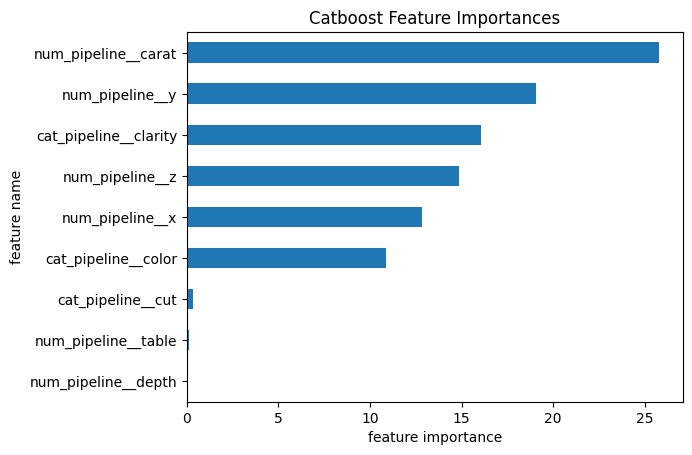

In [30]:
feature_imp = best_cbr.feature_importances_
feature_nm = best_cbr.feature_names_
imp_series = pd.Series(feature_imp)
imp_series.index = feature_nm
print(imp_series.sort_values(ascending=False))
print('\n')
imp_series.sort_values().plot(kind='barh',
                              xlabel='feature importance',
                              ylabel='feature name',
                              title='Catboost Feature Importances')
plt.show()

<div style="background-color: #2d2d2d; color: #f8f8f2; padding: 10px; border-radius: 5px; text-align: center;">
Ends
</div>